<a href="https://colab.research.google.com/github/Park-kxng/NAVER-BOOSTCOURSE-BEYOND-AI-BASIC-2023/blob/main/02_%E1%84%8F%E1%85%A2%E1%84%80%E1%85%B3%E1%86%AF%E1%84%8B%E1%85%A6_%E1%84%80%E1%85%A7%E1%86%AF%E1%84%80%E1%85%AA%E1%84%8C%E1%85%A6%E1%84%8E%E1%85%AE%E1%86%AF%E1%84%92%E1%85%A1%E1%84%80%E1%85%B5_%EB%B0%95%EA%B7%BC%EC%98%81.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1> 캐글에 일단 제출 해보자 </h1>



---
앙상블 기법을 활용하여 좀 더 높은 성능을 갖는 모델을 만들어 볼 것 입니다.이전 미션에 이어서 진행 할 것 입니다. 이전에 완성된 코드는 다음과 같습니다. 먼저 데이터를 다시한번 다운로드 해오겠습니다.


In [ ]:
# 데이터 다운로드
!wget –no-check-certificate 'https://docs.google.com/uc?export=download&id=1IVvuG3SMlarSSGmcliGFjq1fMxZtksE0' -O kaggle-kakr-housing-data.zip

--2023-05-16 11:02:13--  http://xn--no-check-certificate-2t2l/
Resolving xn--no-check-certificate-2t2l (xn--no-check-certificate-2t2l)... failed: Name or service not known.
wget: unable to resolve host address ‘xn--no-check-certificate-2t2l’
--2023-05-16 11:02:13--  https://docs.google.com/uc?export=download&id=1IVvuG3SMlarSSGmcliGFjq1fMxZtksE0
Resolving docs.google.com (docs.google.com)... 142.251.163.101, 142.251.163.100, 142.251.163.138, ...
Connecting to docs.google.com (docs.google.com)|142.251.163.101|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-00-b8-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/vgloa2ec3hu7r071agog9govk3oqa6n3/1684234875000/17597719433809694239/*/1IVvuG3SMlarSSGmcliGFjq1fMxZtksE0?e=download&uuid=b251182a-5998-4409-bf5b-f78af176e83a [following]
--2023-05-16 11:02:15--  https://doc-00-b8-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/vgloa2ec3hu7r071agog9govk3

압축도 풀어줍니다.

In [ ]:
# 다운로드 받은 zip파일 압축풀기
!unzip -qq ./kaggle-kakr-housing-data.zip

replace data/sample_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

지난 번에 작성한 전처리 코드를 실행합니다.

In [ ]:
#--------------------------------------------------------------------------------------------------------------------------------------

train_data_path = join('./data/train.csv')
sub_data_path = join('./data/test.csv')      # 테스트, 즉 submission 시 사용할 데이터 경로

#--------------------------------------------------------------------------------------------------------------------------------------
data = pd.read_csv(train_data_path)
sub = pd.read_csv(sub_data_path)


# data cleaning
# 결측치 대체
from sklearn.impute import SimpleImputer # 결측치 대체

imputer = SimpleImputer(missing_values = np.nan, strategy='mean') # 결측치를 평균값으로 대체합니다.
data = imputer.fit_transform(data) # 결측치를 대체한 배열을 저장합니다.
sub = imputer.fit_transform(sub) # 결측치를 대체한 배열을 저장합니다.

#df = pd.DataFrame(df_data, columns = df.columns) # 대체한 배열로 다시 데이터 프레임을 생성합니다.
# data scaling

#--------------------------------------------------------------------------------------------------------------------------------------
y = data['price']
del data['price']

train_len = len(data)
data = pd.concat((data, sub), axis=0)

sub_id = data['id'][train_len:]
del data['id']

data['date'] = data['date'].apply(lambda x : str(x[:6])).astype(int)

#--------------------------------------------------------------------------------------------------------------------------------------
skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement']

for c in skew_columns:
    data[c] = np.log1p(data[c].values)

#--------------------------------------------------------------------------------------------------------------------------------------
y_log_transformation = np.log1p(y)

sub = data.iloc[train_len:, :] # 테스트 데이터
x = data.iloc[:train_len, :] # 학습데이터

print(x.shape)
print(sub.shape)

(15035, 18)
(6468, 18)


<div class="markdown-google-sans">

## <strong> 앙상블 학습 </strong>
</div>


이제 본격적으로 학습시킬 모델을 준비합니다. 우리는 여러 가지 모델을 함께 사용해서 결과를 섞는, 블렌딩(blending) 이라는 기법을 활용합니다.

앙상블 기법이란 하나의 개별 모델을 사용하는 것이 아니라 다양한 여러 모델을 종합하여 결과를 얻는 기법입니다.

앙상블 학습에 대해서 잘 정리된 내용이 있어서 공유를 해봅니다.  : [Part 1. Introduction to Ensemble Learning](https://subinium.github.io/introduction-to-ensemble-1/#:~:text=%EC%95%99%EC%83%81%EB%B8%94(Ensemble)%20%ED%95%99%EC%8A%B5%EC%9D%80%20%EC%97%AC%EB%9F%AC,%EB%A5%BC%20%EA%B0%80%EC%A7%80%EA%B3%A0%20%EC%9D%B4%ED%95%B4%ED%95%98%EB%A9%B4%20%EC%A2%8B%EC%8A%B5%EB%8B%88%EB%8B%A4.)

앙상블은 강력한 개별 모델 하나보다 약한 여러 개의 모델의 결과를 합치는 것이 낫다는 기본 전제로부터 시작됩니다.

우리는 이번에 회귀 문제를 풀고 있으므로, 위 분류기의 앙상블처럼 투표로 정하는 대신 예측 결과를 평균 내어 활용할 예정입니다.


## Averaging
부스팅 계열의 `gboost`, `xgboost`, `lightgbm`을 산술평균하는 앙상블 모델을 만들어볼 겁니다. 코드는 아래와 같습니다.

In [ ]:
gboost = GradientBoostingRegressor(random_state=2023)
xgboost = xgb.XGBRegressor(random_state=2023)
lightgbm = lgb.LGBMRegressor(random_state=2023)

models = [{'model':gboost, 'name':'GradientBoosting'}, {'model':xgboost, 'name':'XGBoost'},
          {'model':lightgbm, 'name':'LightGBM'}]

**Cross Validation**

먼저 교차 검증을 통해 모델의 성능을 측정하는 함수를 만들어 보겠습니다.

In [ ]:
def get_cv_score(models):
    kfold = KFold(n_splits=5).get_n_splits(x.values)
    for m in models:
        CV_score = np.mean(cross_val_score(m['model'], X=x.values, y=y, cv=kfold))
        print(f"Model: {m['name']}, CV score:{CV_score:.4f}")

이제 `get_cv_score`함수에 우리의 모델을 넣고 테스트 해보겠습니다.

In [ ]:
get_cv_score(models)

Model: GradientBoosting, CV score:0.8609
Model: XGBoost, CV score:0.8861
Model: LightGBM, CV score:0.8819


`cross_val_score()` 함수는 회귀모델을 전달할 경우 $R^2$ 점수를 반환합니다. $R^2$ 값은 1에 가까울수록 모델이 잘 학습되었다는 것을 나타냅니다. 결정계수 $R^2$ 값에 대한 간단한 설명은 아래의 링크 글을 참고하세요.

- [결정계수 $R^2$](https://newsight.tistory.com/259)

우리가 참가한 캐글대회에서 제공하는 Baseline 모델에서는 다음과 같이 여러 모델을 입력하면 각 모델에 대한 예측 결과를 평균 내어주는 `AveragingBlending()` 함수를 만들어 사용합니다.

`AveragingBlending()` 함수는 models 딕셔너리 안에 있는 모델을 모두 `x`와 `y`로 학습시킨 뒤 `predictions`에 그 예측 결
과값을 모아서 평균한 값을 반환합니다.

In [ ]:
def AveragingBlending(models, x, y, sub_x):
    # 모델학습
    for m in models :
        m['model'].fit(x.values, y)

    # 모델예측
    predictions = np.column_stack([
        m['model'].predict(sub_x.values) for m in models
    ])

    # 각 모델 에측의 평균을 return
    return np.mean(predictions, axis=1)

이제 우리의 모델에 데이터를 넣고 결과를 확인해 보겠습니다.

In [ ]:
y_pred = AveragingBlending(models, x, y, sub)
print(len(y_pred))
y_pred

6468


array([ 529966.66304912,  430726.21272617, 1361676.91242777, ...,
        452081.69137012,  341572.97685942,  421725.1231835 ])

적당한 실수값들로 예측을 해낸 것 같습니다. 그렇다면 우리는 이 결과를 캐글에 제출하기 위해 어떻게 해야 할까요?

제출해야 하는 csv 파일의 샘플이 바로 `data` 폴더에 있는 `sample_submission.csv` 입니다.
다음 코드로 `sample_submission.csv` 파일을 확인해보겠습니다.

In [ ]:
submission = pd.read_csv('./data/sample_submission.csv')
submission.head()

,id,price
0,15035,100000
1,15036,100000
2,15037,100000
3,15038,100000
4,15039,100000


제출 파일은 `id`와 `price` 두 가지 열로 구성되어 있습니다. 그렇다면 우리도 `id`와 `price`로 구성된 데이터 프레임을 만들어 주도록 하겠습니다.

In [ ]:
result = pd.DataFrame({
    'id' : sub_id,
    'price' : y_pred
})

result.head()

,id,price
0,15035,5.299667e+05
1,15036,4.307262e+05
2,15037,1.361677e+06
3,15038,3.338036e+05
4,15039,3.089006e+05


<div class="markdown-google-sans">

## 미션 1) 모델 예측결과를 csv로 만들기
</div>


이제 완전히 준비가 끝났습니다. 이때 활용할 수 있는 함수는 [`to_csv()`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.to_csv.html)함수 입니다.
샘플 형태인 `sample_submission.csv`를 로드했을 때와 동일한 형식으로 저장해야만 정확하게 제출될 것 입니다.

In [ ]:
# 저장할 파일명은 submission.csv로 하였습니다.
my_submission_path = './data/submission.csv'

###################
###  미션 1 코드 ####
###################
# result를 'my_submission_path'란 이름의 csv로 저장해 주세요.
result.to_csv(my_submission_path, index = False) # result를 'my_submission_path'란 이름의 csv로 저장
pd.read_csv(my_submission_path) # csv로 잘 저장되어 있는지 확인합니다.

,id,price
0,15035,5.299667e+05
1,15036,4.307262e+05
2,15037,1.361677e+06
3,15038,3.338036e+05
4,15039,3.089006e+05
...,...,...
6463,21498,2.478657e+05
6464,21499,4.156358e+05
6465,21500,4.520817e+05
6466,21501,3.415730e+05


## Baseline 모델학습 결과를 제출해 보기
일단 저장된 `submission.csv` 파일을 아래의 그림과 같이 여러분의 컴퓨터로 다운로드 하겠습니다. (Colab에서 진행하는게 아니라면 무시하셔도 됩니다. 이미 여러분의 로컬 컴퓨터에 저장되어 있을테니까요)

Colab의 경우 아래의 그림처럼 왼쪽의 폴더 모양을 누르신 후 `data`폴더에서 `submission.csv` 파일을 선택하신 후 다운로드 해주세요.




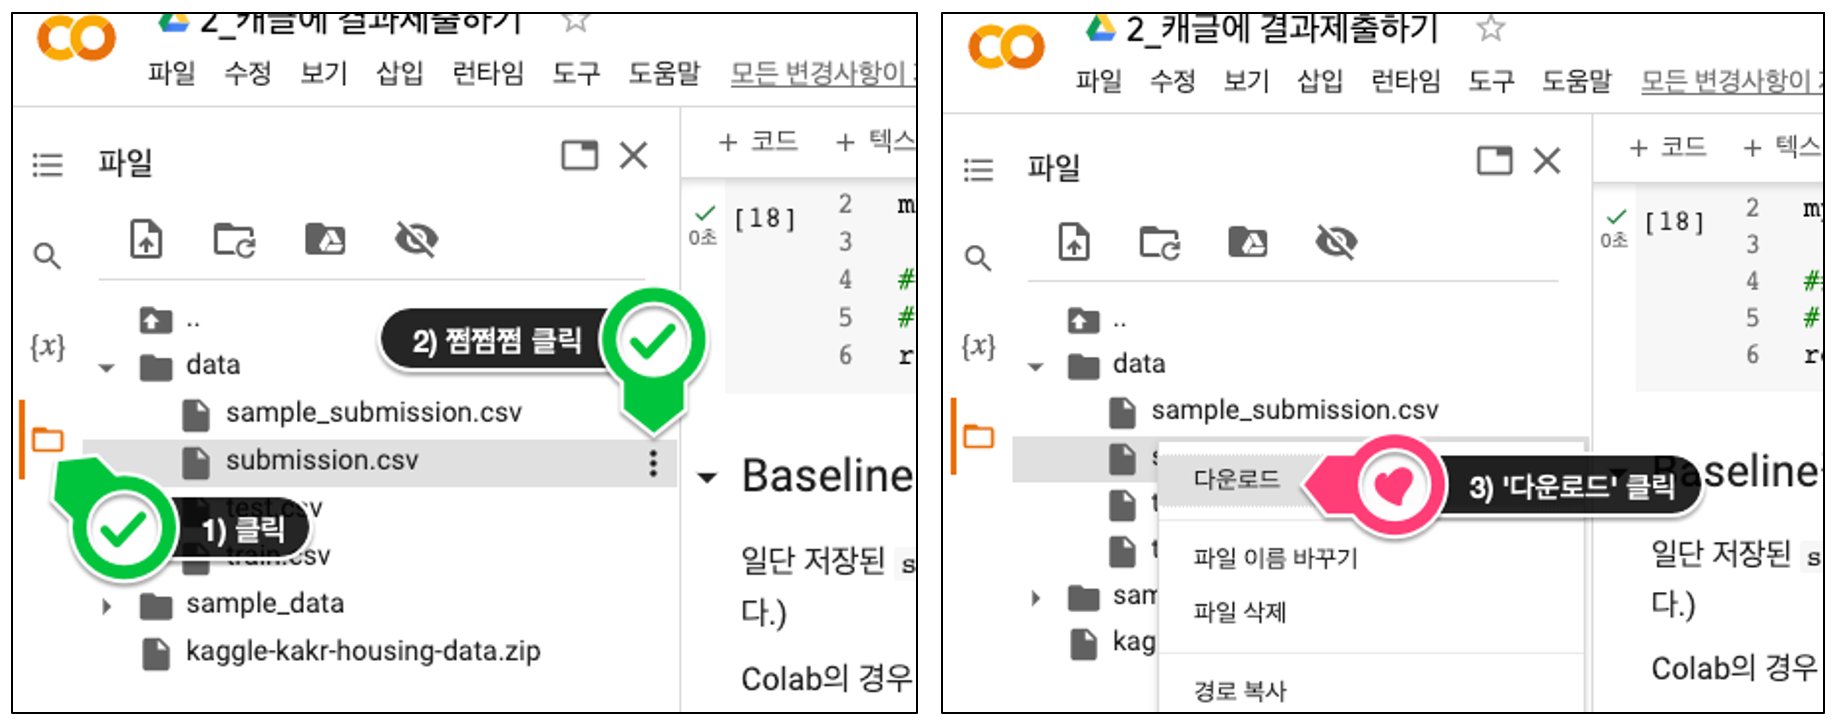

## 캐글 사이트에 제출하기

이제 다운로드 받은 파일을 제출해볼것 입니다.
앞서 말했다시피 이번 대회는 이미 끝난 대회이기 때문에 `Late Submission`만 가능한 상태입니다.
아래와 같이 탭에 있는 `Late Submission `버튼을 클릭하면 다음과 같은 화면을 만날 수 있습니다 (**로그인을 하셔야 제출하실 수 있습니다.**)

- [캐글 코리아와 함께하는 2nd ML대회](https://www.kaggle.com/c/2019-2nd-ml-month-with-kakr)

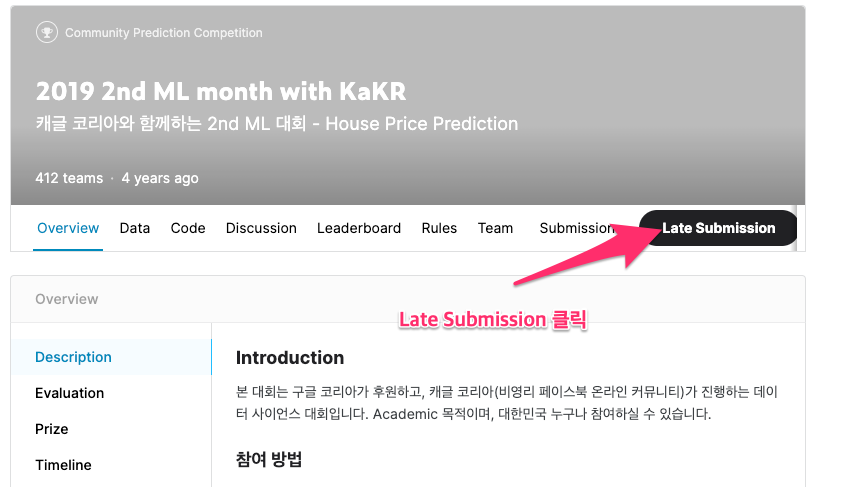

이제 여러분이 다운로드 받은 파일을 drag&drop으로 제출해주세요.
**제출할때 메세지까지 작성해주셔야 '제출버튼'이 활성화 될 것 입니다.** 활성화되면 제출을 완료해주세요. 완료되면 다음과 같은 화면이 나타날 겁니다.





제출이 완료되면 다음 그림과 같은 화면이 나타날 것 입니다.  




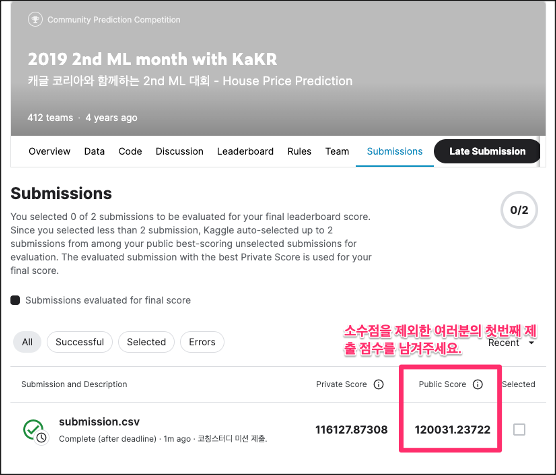

### 미션 2-1) 여러분이 제출한 Public Score는 몇점이신가요?
소수점을 제외한 첫번째 제출 점수를 이곳에 작성해 주세요.




```
119927점입니다.
```



### 미션 2-2) 슬랙(Slack)에 여러분의 첫번째 제출결과를 스크린 캡쳐하여 공유해주세요.

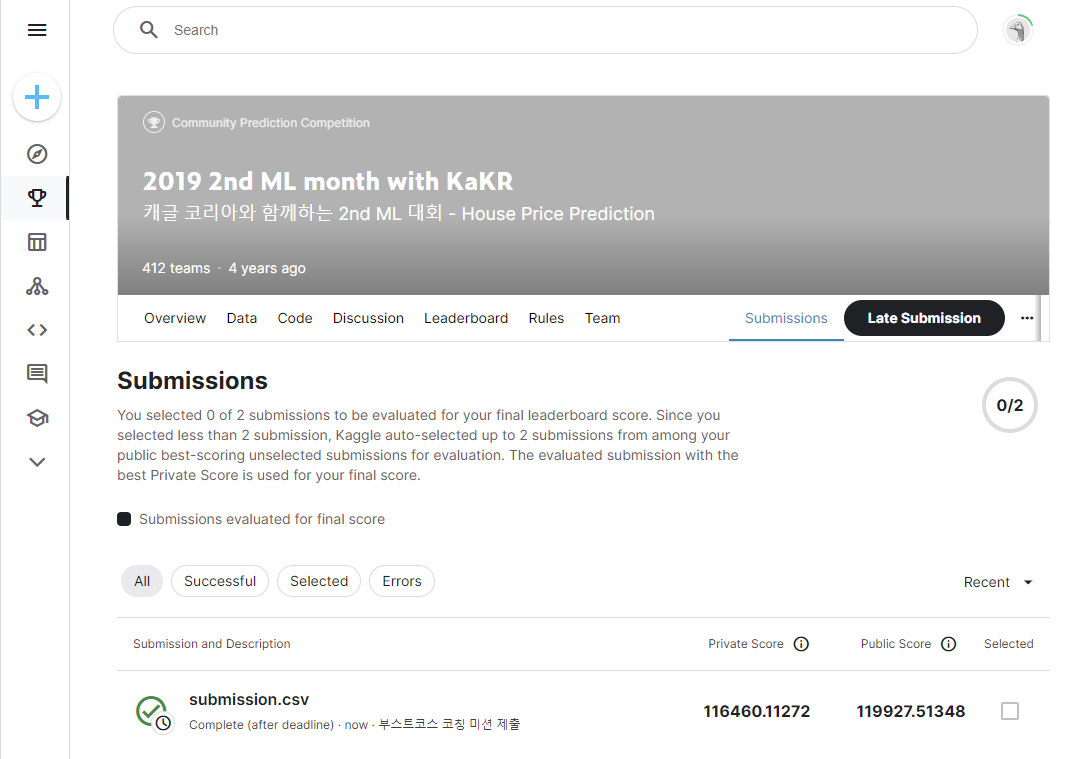

영역을 스크린 캡쳐하는 방법은 간단합니다. 다음의 단축키가 유용할 것 입니다.
- 윈도우 유저 (윈도우 10이상이 가능) : `윈도우키`+`Shift`+`s`
- 맥 유저 : `cmd` + `Ctrl` + `Shift` + `4`

이렇게하면 영역을 캡쳐할 수 있고 슬랙 대화창에서 'ctrl + v'로 쉽게 여러분의 결과를 공유할 수 있습니다. 각자 여러분이 속한 슬랙채널에 공유하여 여러분의 친구들이 잘 하고 있는지 서로 도와주세요.

**공유하셨다면 "예"를 아니면 "아직 아니요"라고 밑에 작성해주세요.**


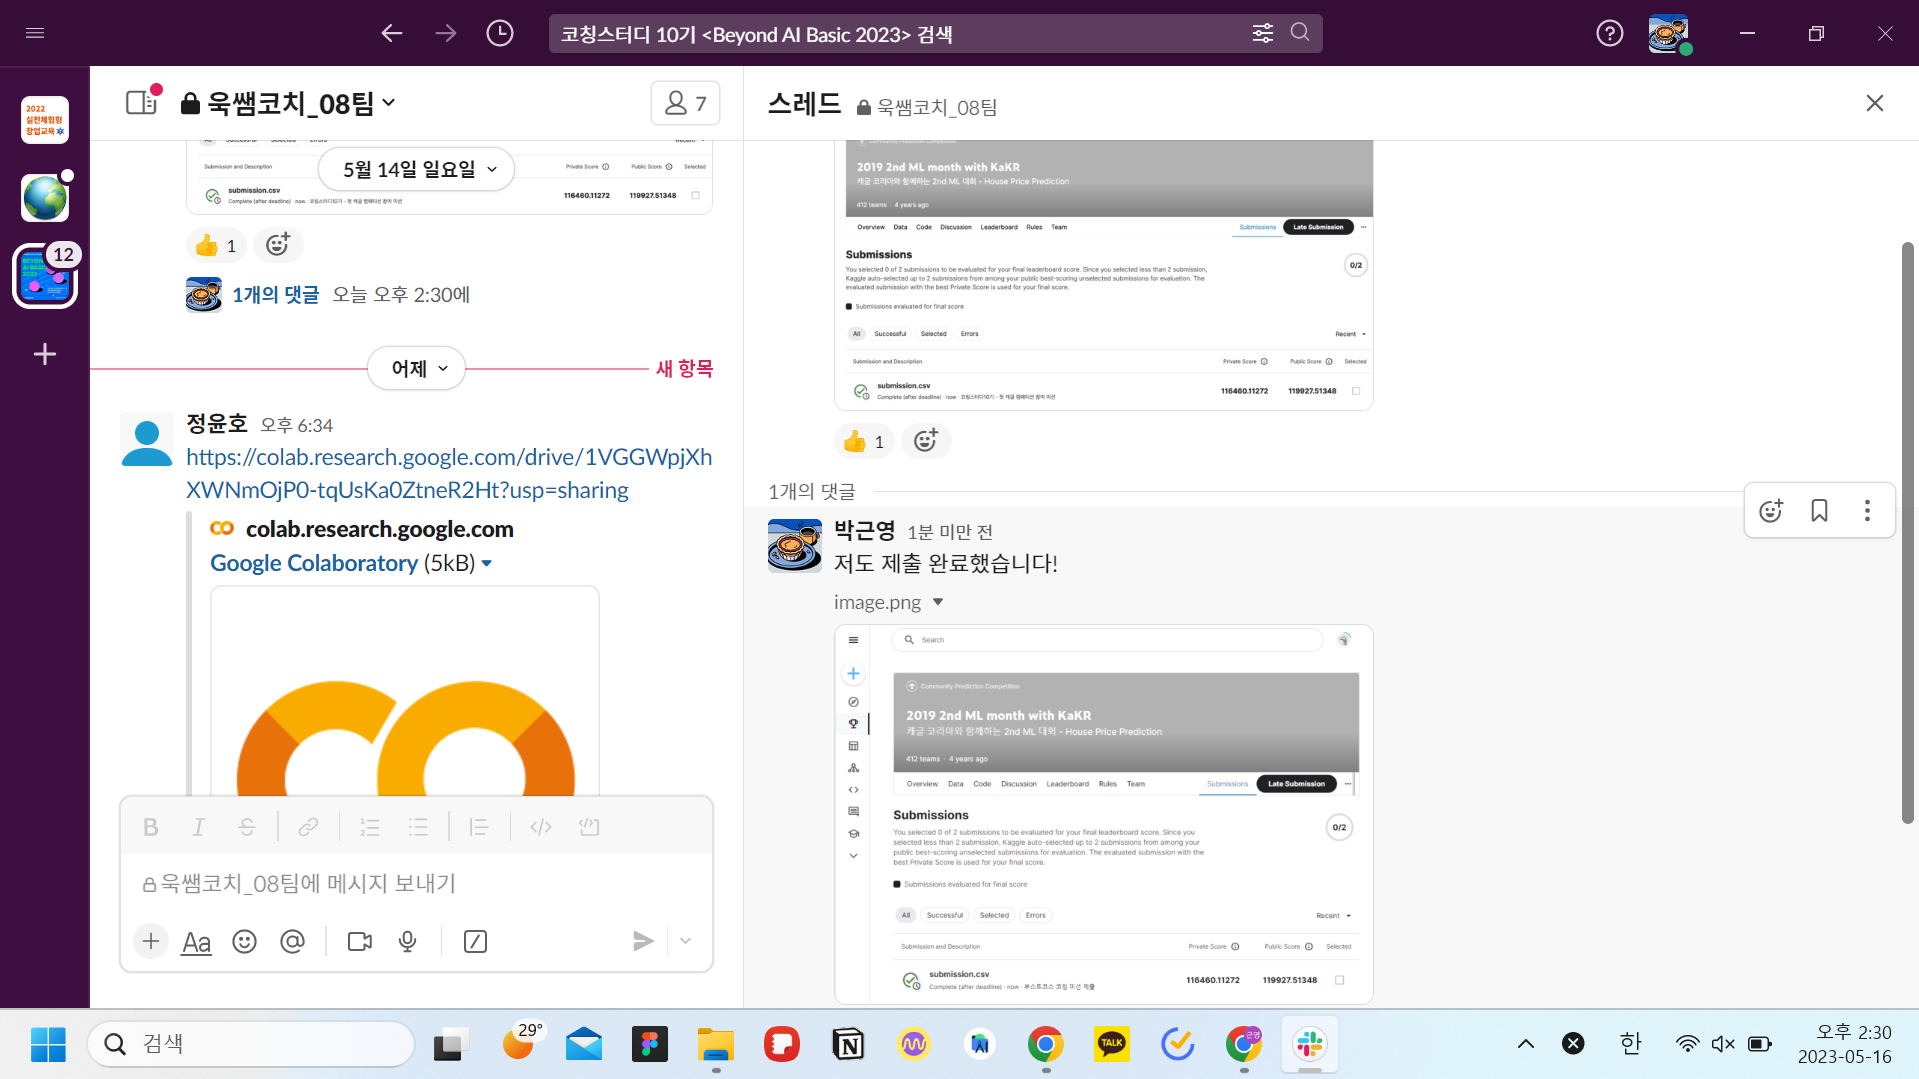



```
# 예
```



이 대회는 지난 대회이기 때문에 여러분의 결과가 `Leaderboard`에 등록되지 않습니다. 그러나 여러분의 결과가 어느정도 순위인지`Leaderboard`를 통해서 직접 확인해 보실 수는 있습니다.

## 더 좋은 성능의 모델 만들기

이제부터는 제공된 베이스라인 모델이 아닌 우리 스스로 모델을 만들어 보도록 하겠습니다. 일단 베이스라인에서 모델학습을 진행하였고 전처리도 진행하였기 때문에 이는 그대로 가보려고 합니다.

`price`인 `y`는 지난번 살펴본 것처럼 그 분포가 왼쪽으로 크게 치우져 있었기 때문에 [`np.log1p()`](https://numpy.org/doc/stable/reference/generated/numpy.log1p.html) 함수를 이용하여 로그변환을 해주고 모델 에측이 끝났을 때 그 역함수인 [`np.expm1()`](https://numpy.org/doc/stable/reference/generated/numpy.expm1.html)을 이용하여 돌려 놓겠습니다.

In [ ]:
train = x # 기존 학습 데이터를 train으로
test = sub # 기존 테스트 데이터를 test로
y = np.log1p(y) # y값(price)의 로그변환

### RMSE 계산함수 만들기
RMSE를 계산하는 함수를 만들어 보겠습니다. `sklearn` 패키지를 활용할 것 입니다. 먼저 [`train_test_split`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)과 [`mean_squared_error`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html)를 가져옵니다.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

한 가지 주의해야 할 것은 아래의 `y_test`나 `y_pred`는 위에서 `np.log1p()`로 변환된 값이기 때문에 원래 데이터의 단위에 맞게 되돌리기 위해 `np.expm1()`을 추가해야 한다는 점 입니다.
따라서 RMSE를 구하는 함수는 다음과 같습니다.

In [ ]:
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

다음으로 `XGBRegressor`, `LGBMRegressor`,`GradientBoostingRegressor`, `RandomForestRegressor` 네 가지 모델을 가져오겠습니다.

In [ ]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

아래와 같이 모델 인스턴스를 생성한 후 models라는 리스트에 넣어줍니다.

In [ ]:
# random_state는 모델초기화나 데이터셋 구성에 사용되는 랜덤 시드값입니다.
#random_state=None    # 이게 초기값입니다. 아무것도 지정하지 않고 None을 넘겨주면 모델 내부에서 임의로 선택합니다.
random_state=2023        # 하지만 우리는 이렇게 고정값을 세팅해 두겠습니다.

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]

이때, 모델 파라미터 초기화나 데이터셋 구성에 사용되는 랜덤 시드값인 random_state 값을 특정 값으로 고정시키거나 지정하지 않고 None으로 세팅할 수 있습니다. random_state를 고정값으로 주면 모델과 데이터셋이 동일한 경우 머신러닝 학습결과도 항상 동일하게 재현됩니다. 하지만 이 값을 지정하지 않고 None으로 남겨 두면 모델 내부에서 랜덤 시드값을 임의로 선택하기 때문에, 결과적으로 파라미터 초기화나 데이터셋 구성 양상이 달라져서 모델과 데이터셋이 동일하더라도 머신러닝 학습결과는 학습할 때마다 달라집니다.

앞으로 우리는 베이스라인에서부터 시작해서 다양한 실험을 통해 성능이 개선되는지를 검증해 보려고 합니다. 이때, 어떤 시도가 모델 성능 향상에 긍정적이었는지 여부를 판단하기 위해서는 랜덤적 요소의 변화 때문에 생기는 불확실성을 제거해야 합니다. 따라서 아래와 같이 random_state 값을 특정 값으로 고정시킬 것입니다.

<div class="markdown-google-sans">

## 스코어를 출력하는 함수 만들기
</div>


아래의 코드는 위에서 만들어둔 모델을 순환하면서 그 결과를 `score_df`라는 DataFrame으로 반환하는 함수입니다. `get_score`함수이고 함수 파라미터로 다음을 받습니다.

`def get_scores(models, train, y)`
- `models` : model을 가지고 있는 list
- `train` : 학습 데이터 (함수 내부에서 validation 데이터로도 나뉨)
- `y` : 학습할 때 사용할 정답 레이블 데이터

In [ ]:
def get_scores(models, train, y):
    df = {} # 결과 저장을 위한 table 생성
    for model in models: # 모델명 추출
        model_name = model.__class__.__name__
        # 0.2만 validation에 사용
        X_train, X_val, y_train, y_val = train_test_split(train, y, random_state=random_state, test_size=0.2)

        # 모델학습
        model.fit(X_train, y_train)

        #학습된 모델 테스트
        y_pred = model.predict(X_val)

        # rmse를 이용한 계산
        df[model_name] = rmse(y_val, y_pred)

        # 테이블을 DataFrame으로 변환
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
    return score_df

이제 우리가 RMSE로 결과를 만들어주는 함수가 준비되었으니 다양한 하이퍼 파라미터로 실험하는 일만 남았습니다.

실험은 `sklearn.model_selection` 라이브러리 안에 있는 `GridSearchCV` 클래스를 활용합니다.
다음 함수를 import 해주세요!

In [ ]:
from sklearn.model_selection import GridSearchCV

`GridSearchCV`란 무엇일까요?

우선 그리드 탐색과 랜덤 탐색을 알아볼 필요가 있습니다. 두 가지 모두 하이퍼 파라미터를 조합해 보는 방법입니다.

그리드 탐색은 사람이 먼저 탐색할 하이퍼 파라미터의 값들을 정해두고, 그 값들로 만들어질 수 있는 모든 조합을 탐색합니다. 특정 값에 대한 하이퍼 파라미터 조합을 모두 탐색하고자 할 때 유리하겠네요!

랜덤 탐색은 사람이 탐색할 하이퍼 파라미터의 공간만 정해두고, 그 안에서 랜덤으로 조합을 선택해서 탐색하는 방법입니다.

그리드 탐색에서는 사람이 정해둔 값들로 이루어지는 조합만 탐색하기 때문에 최적의 조합을 놓칠 수 있는 반면, 랜덤 탐색에서는 말 그대로 랜덤으로 탐색하기 때문에 최적의 조합을 찾을 수 있는 가능성이 언제나 열려 있습니다. 하지만 그 가능성 또한 랜덤성에 의존하기 때문에 언제나 최적을 찾는다는 보장은 없어요.

다음 이미지가 그리드 탐색(grid search)과 랜덤 탐색(random search) 두 가지를 잘 나타내고 있습니다.
그리드 탐색은 정해진 하이퍼 파라미터의 조합을 격자와 같이 탐색하는 반면, 랜덤 탐색은 랜덤으로 점을 찍어서 탐색합니다.

확실히 그리드 탐색의 탐색 공간은 매우 제한적인 반면 랜덤 탐색은 탐색하는 공간이 훨씬 넓습니다.

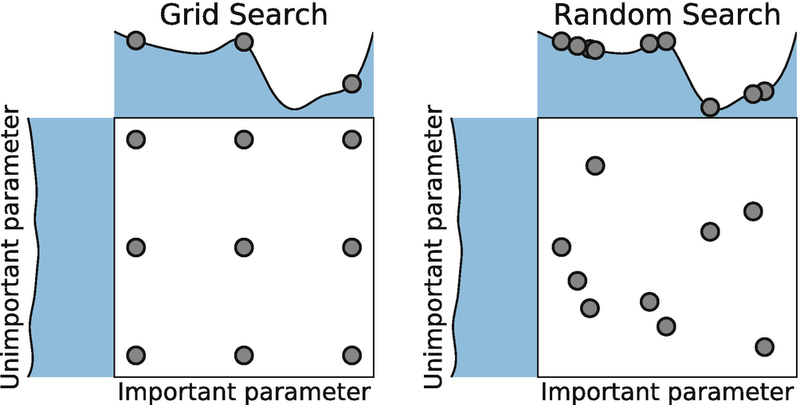

> 그림설명 : [Bergstra, J., Bengio, Y.: Random search for hyper-parameter optimization. Journal of Machine Learning Research 13, 281–305 (2012), 다음의 블로그에서 재인용]

우리는 앞서 언급했듯 다양한 파라미터를 입력하면 가능한 모든 조합을 탐색하는 사이킷런의 `GridSearchCV`를 활용해 볼 것입니다.

먼저 `GridSearchCV`에 입력되는 인자들은 다음과 같습니다.

- `param_grid` : 탐색할 파라미터의 종류 (딕셔너리로 입력)
- `scoring` : 모델의 성능을 평가할 지표
- `cv` : cross validation을 수행하기 위해 train 데이터셋을 나누는 조각의 개수
- `verbose` : 그리드 탐색을 진행하면서 진행 과정을 출력해서 보여줄 메세지의 양 (숫자가 클수록 더 많은 메세지를 출력합니다.)
- `n_jobs` : 그리드 탐색을 진행하면서 사용할 CPU의 개수

그러면 param_grid에 탐색할 xgboost 관련 하이퍼 파라미터를 넣어서 준비하겠습니다.

In [ ]:
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [1, 10],
}

그다음으로 모델을 준비합니다. 모델은 LightGBM(lgbm)를 사용해봅시다.

In [ ]:
model = LGBMRegressor(random_state=random_state)

그러면 `model`, `param_grid`와 함께 다른 여러 가지 인자를 넣어서 `GridSearchCV`를 수행할 수 있습니다!

다음과 같이 `GridSearchCV`를 이용해서 `grid_model` 모델을 초기화하고, `train`과 `y` 데이터로 모델을 간단히 학습시키면 `param_grid` 내의 모든 하이퍼 파라미터의 조합에 대해 실험이 완료됩니다.

In [ ]:
grid_model = GridSearchCV(model, param_grid=param_grid, \
                        scoring='neg_mean_squared_error', \
                        cv=5, verbose=1, n_jobs=5)

grid_model.fit(x, y)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


GridSearchCV(cv=5, estimator=LGBMRegressor(random_state=2023), n_jobs=5,
             param_grid={'max_depth': [1, 10], 'n_estimators': [50, 100]},
             scoring='neg_mean_squared_error', verbose=1)

### 생강먹고 생각 좀 해 1 : 위에 출력된 메세지에 나타난 'totalling 20 fits' 에서 20은 어떻게 계산된 값일까요?



```
 GridSearchCV란 머신러닝에서 모델의 성능향상을 위해 쓰이는 기법 중 하나로,
사용자가 직접 모델의 하이퍼 파라미터의 값을 리스트로 입력하면 값에 대한 경우의
수마다 예측 성능을 측정 평가하여 비교하면서 최적의 하이퍼 파라미터 값을 찾는
과정을 진행합니다. 현재 param_grid에 탐색할 하이퍼 파라미터는 n_estimators
에서 2개, max_depth에서 2개입니다. 각각의 요소의 경우의 수는 2x2로 총 4개의
조합이 생성됩니다.(ex. (n_estimators, max_depth) -> (50,1),(100,1),(50,10),(100,10))

 cv는 cross validation을 수행하기 위해 train 데이터셋을 나누는 조각의 개수입니다.
위에서의 코드에서 grid_model의 cv는 5로 선언하였습니다. 교차 검증을 위해 5개의
부분 집합으로 나눈다는 의미입니다.
따라서, 4개의 하이퍼 파라미터 조합에 대해 5-fold 교차 검증을 실행하면
4x5=20으로 총 20번의 피팅이 이루어집니다.


```



이제 `grid_model.fit` 함수를 통해서 4가지 조합에 대한 실험을 모두 마쳤습니다.

실험에 대한 결과는 다음과 같이 `grid_model.cv_results_` 안에 저장됩니다.

In [ ]:
grid_model.cv_results_

{'mean_fit_time': array([0.5459002 , 0.56725907, 1.0023232 , 1.16394701]),
 'std_fit_time': array([0.05450717, 0.0835707 , 0.13446439, 0.15361273]),
 'mean_score_time': array([0.03259454, 0.03853855, 0.05179968, 0.05830092]),
 'std_score_time': array([0.01078623, 0.01365062, 0.01606934, 0.03079935]),
 'param_max_depth': masked_array(data=[1, 1, 10, 10],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_n_estimators': masked_array(data=[50, 100, 50, 100],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'max_depth': 1, 'n_estimators': 50},
  {'max_depth': 1, 'n_estimators': 100},
  {'max_depth': 10, 'n_estimators': 50},
  {'max_depth': 10, 'n_estimators': 100}],
 'split0_test_score': array([-0.0756974 , -0.05555652, -0.02885212, -0.02664695]),
 'split1_test_score': array([-0.07666447, -0.057876  , -0.03041411, -0.02795762]),
 'split2_test_score': array([-0.07354904

정보가 너무 많아서 눈에 잘 들어오지 않으니 원하는 값만 정제해서 확인하도록 하겠습니다.

우리가 관심 있는 정보는 어떤 파라미터 조합일 때 점수가 어떻게 나오게 되는지에 관한 것이겠죠.
파라미터 조합은 위 딕셔너리 중 `params`에, 각각에 대한 테스트 점수는 `mean_test_score`에 저장되어 있습니다.

이 두 정보만 빼내어 보겠습니다.

In [ ]:
params = grid_model.cv_results_['params']
params

[{'max_depth': 1, 'n_estimators': 50},
 {'max_depth': 1, 'n_estimators': 100},
 {'max_depth': 10, 'n_estimators': 50},
 {'max_depth': 10, 'n_estimators': 100}]

In [ ]:
score = grid_model.cv_results_['mean_test_score']
score

array([-0.07339763, -0.05502319, -0.02917323, -0.02702383])

**테이터 프레임 합쳐서 표현해 보기**

`params`에는 각 파라미터의 조합이, `score`에는 각 조합에 대한 점수가 들어가 있군요.

이제 이 둘만 가지고 데이터 프레임을 만들고 최적의 성능을 내는 하이퍼 파라미터의 조합을 찾아봅시다.

다음과 같은 형태의 데이터 프레임을 출력하는 코드를 작성해 보겠습니다.


|max_depth| n_estimators| score|
|---|---|---|
|1|50|-0.07339763|
|1|100|-0.05502319|
|10|50|-0.02917323|
|10|100|-0.02702383|

In [ ]:
results = pd.DataFrame(params)
results['score'] = score

results


,max_depth,n_estimators,score
0,1,50,-0.073398
1,1,100,-0.055023
2,10,50,-0.029173
3,10,100,-0.027024


자, 그런데 여기에서 한 가지 의문이 드는 것이 있습니다. 왜 점수는 음수일까요?!

그 이유는 바로 GridSearchCV을 초기화 한 코드에 힌트가 있습니다.
우리가 위에서 GridSearchCV로 grid_model 모델을 초기화할 때, scoring 인자에 무엇을 넣었는지 기억하시나요?

### 생각먹고 생각 좀 해 2 : GridSearchCV 에서 모델을 초기화할 때 scoring 인자에는 무엇을 넣었나요?


```
# 정답작성 : neg_mean_squared_error
```


`GridSearchCV`를 사용할 때에는 이 외에도 다양한 점수 체계(scoring)를 사용할 수 있습니다. 그에 대한 정보는 다음 페이지에서 확인하겠습니다.

- [사이킷런 - The scoring parameter: defining model evaluation rules](https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter)

### 생강먹고 생각 좀 해 3 : 위 링크의 scoring parameter 표를 보면 이 파라미터를 3개의 범주로 묶어서 표기해주고 있습니다. 이 3개의 범주가 무엇인가요? 각자의 답을 슬랙에서 공유해주세요.


```
# classification, clustering, regression
```


**`생강먹고 생각 좀 해` 부분을 각자 슬랙에서 답도 써보고, 물어보고, 토론해 보세요. 활발한 논의들이 일어나길 기대합니다.**

우리는 현재 Regression 문제를 풀고 있기 때문에 그에 알맞은 성능 평가 지표를 사용하였습니다.
우리가 사용한 것이 `neg_mean_squared_error`를 사용했기 때문에 점수가 음수로 표현되는 것이죠!

아래와 같은 간단한 변환 함수로 RMSE 점수를 볼 수 있도록 하겠습니다.
음수로 된 MSE였으니, -1을 곱해주고 np.sqrt로 루트 연산을 해주면 되겠죠.

In [ ]:
results['RMSE'] = np.sqrt(-1 * results['score'])
results

,max_depth,n_estimators,score,RMSE
0,1,50,-0.073398,0.270920
1,1,100,-0.055023,0.234570
2,10,50,-0.029173,0.170802
3,10,100,-0.027024,0.164389


앗, 하지만 아직도 위에서 보았던 10만 단위의 RMSE와는 값의 크기가 아주 다른 것 같습니다.

그 이유는 `price`에 있습니다. 위에서 우리는 `price`의 분포가 한쪽으로 치우쳐져 있는 것을 보고 log 변환을 했었죠.
그 후 rmse 값을 계산하기 위한 함수에서는 `np.expm1` 함수를 활용해 다시 원래대로 복원한 후 RMSE 값을 계산했습니다.

하지만 그리드 탐색을 하면서는 `np.expm1()`으로 변환하는 과정이 없었기 때문에 log 변환되어 있는 `price` 데이터에서 손실함수값을 계산한 것이죠.
따라서 사실, 위의 데이터 프레임에 나타난 값은 정확히 말하면 RMSE가 아니라 RMSLE, 즉 Root Mean Squared Log Error 입니다.
log를 취한 값에서 RMSE를 구했다는 뜻이죠!

## 미션 3-1) : 컬럼명 바꾸기
`RMSE` 컬럼의 이름을 RMSLE로 변환해 주도록 하겠습니다. 판다스에서 컬럼의 이름 변환은 [rename](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.rename.html)으로 할 수 있습니다. 아래에 코드를 작성하고 출력해보세요.

In [ ]:
###################
###  미션 3-1 코드 ###
###################
## 미션 3-1) 컬럼명 바꾸기

# rename을 통해 컬럼 RMSE의 이름을 RMSLE 으로 변환합니다.
results.rename(columns = {'RMSE' :'RMSLE'}, inplace = True)
# results의 column명이 바뀐 것을 확인합니다.
results

,max_depth,n_estimators,score,RMSLE
0,1,50,-0.073398,0.270920
1,1,100,-0.055023,0.234570
2,10,50,-0.029173,0.170802
3,10,100,-0.027024,0.164389


이제 마지막 할 일은 RMSLE가 낮은 순서대로 정렬하는 것뿐이군요!


## 미션 3-2) : RMSLE를 낮은 순서대로 정렬하기
sort_values로 간단히 할 수 있습니다. 공식 문서를 참고해 직접 작성해 보세요.

In [ ]:
###################
###  미션 3-2 코드 ###
###################
## 미션 3-2 : results 데이터 프레임에서 RMSLE가 낮은 순으로 정렬하기
results = results.sort_values('RMSLE', ascending = True) # 컬럼 RMSLE을 기준으로 오름차순으로 데이터프레임을 정렬합니다.
results

,max_depth,n_estimators,score,RMSLE
3,10,100,-0.027024,0.164389
2,10,50,-0.029173,0.170802
1,1,100,-0.055023,0.234570
0,1,50,-0.073398,0.270920


## 미션 4) : 함수로 만들기
지금까지의 `GridSearchCV`를 통해 진행한 내용들을 간단히 함수로 만들어 보도록 하겠습니다.

다음과 같은 과정을 진행할 수 있는 `my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)` 함수를 구현해 보세요.

1. GridSearchCV 모델로 `model`을 초기화합니다.
2. 모델을 fitting 합니다.
3. params, score에 각 조합에 대한 결과를 저장합니다.
4. 데이터 프레임을 생성하고, RMSLE 값을 추가한 후 점수가 높은 순서로 정렬한 `results`를 반환합니다.

In [ ]:
###################
###  미션 4-3 코드 ###
###################
## 미션 4-3 : 함수로 만들기

def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    # GridSearchCV 모델로 초기화
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', \
                              cv=5, verbose=verbose, n_jobs=n_jobs)

    # 모델 fitting
    grid_model.fit(train, y)

    # 결과값 저장
    params = grid_model.cv_results_['params'] # '...' 에 코드 작성
    score = grid_model.cv_results_['mean_test_score'] # '...' 에 코드 작성

    # 데이터 프레임 생성
    results = pd.DataFrame(params)
    results['score'] = score # '...'에 코드 작성

    # RMSLE 값 계산
    results['RMSLE'] = np.sqrt(-1 * results['score']) # '...'에 코드작성

    # RMSLE 값으로 장렬
    results = results.sort_values('RMSLE', ascending = True) # '...'에 코드작성

    return results

## 하이퍼 파라미터 튜닝결과 제출해보기

이제 실험에 대한 준비는 모두 끝났습니다! 실험을 통해 좋은 결과를 내는 모델을 찾았다면 제출을 해봐야겠죠.
제출 과정 또한 하나의 함수로 깔끔하게 진행하겠습니다.

먼저 여러분이 만들어놓은 `my_GridSearch()` 함수로 간단한 그리드 탐색을 해보겠습니다.






In [ ]:
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [1, 10],
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


,max_depth,n_estimators,score,RMSLE
3,10,100,-0.027024,0.164389
2,10,50,-0.029173,0.170802
1,1,100,-0.055023,0.234570
0,1,50,-0.073398,0.270920


가장 좋은 조합은 `max_depth=10`, `n_estimators=100` 이군요.
해당 모델로 학습을 해서 예측값인 `submission.csv` 파일을 만들어서 제출해보겠습니다.

먼저 해당 파라미터로 구성된 모델을 준비하고, 학습 후 예측 결과를 생성합니다.

In [ ]:
model = LGBMRegressor(max_depth=10, n_estimators=100, random_state=random_state)
model.fit(train, y)
prediction = model.predict(test)
prediction

array([13.13580793, 13.08051399, 14.11202067, ..., 13.01592878,
       12.69894979, 12.96297768])

앗, 예측 결과에 `np.expm1()`을 씌워서 다시 원래 스케일로 되돌리는 것도 잊으면 안 되겠죠!

In [ ]:
prediction = np.expm1(prediction)
prediction

array([ 506766.66784595,  479506.10405112, 1345155.15609376, ...,
        449515.92243642,  327402.87855805,  426332.71354302])

샘플로 제공받은 `sample_submission.csv` 파일을 로드해보겠습니다. 거기에 덮어씌우면 되기 때문입니다.

In [ ]:
submission_path = './data/sample_submission.csv'
submission = pd.read_csv(submission_path)
submission.head()

,id,price
0,15035,100000
1,15036,100000
2,15037,100000
3,15038,100000
4,15039,100000


위의 데이터프레임에 우리의 모델이 예측한 값을 덮어씌우겠습니다.


In [ ]:
submission['price'] = prediction
submission.head()

,id,price
0,15035,5.067667e+05
1,15036,4.795061e+05
2,15037,1.345155e+06
3,15038,3.122579e+05
4,15039,3.338645e+05


위의 데이터를 csv 파일로 저장하겠습니다.

단, 앞으로는 많은 실험이 있을 예정이니 파일 이름에 모델의 종류와 위에서 확인했던 RMSLE 값을 넣어주면 제출 파일들이 깔끔하게 관리될 것입니다!

In [ ]:
submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format('./data', 'lgbm', '0.164399')
submission.to_csv(submission_csv_path, index=False)
print(submission_csv_path)

./data/submission_lgbm_RMSLE_0.164399.csv


위의 과정들도 하나의 함수로 정리해두면 사용하기 편리하겠죠.

In [ ]:
"""
아래의 과정을 수행하는 `save_submission(model, train, y, test, model_name, rmsle)` 함수.
1. 모델을 `train`, `y`로 학습시킵니다.
2. `test`에 대해 예측합니다.
3. 예측값을 `np.expm1`으로 변환하고, `submission_model_name_RMSLE_100000.csv` 형태의 `csv` 파일을 저장합니다.
"""

def save_submission(model, train, y, test, model_name, rmsle=None):
    model.fit(train, y)
    prediction = model.predict(test)
    prediction = np.expm1(prediction)
    data_dir = './data'
    submission_path = join(data_dir, 'sample_submission.csv')
    submission = pd.read_csv(submission_path)
    submission['price'] = prediction
    submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, model_name, rmsle)
    submission.to_csv(submission_csv_path, index=False)
    print('{} saved!'.format(submission_csv_path))

이 함수를 사용한다면 다음 한 줄로 모델을 학습시킨 후 예측 결과를 저장할 수 있습니다.

In [ ]:
save_submission(model, train, y, test, 'lgbm', rmsle='0.164399')

./data/submission_lgbm_RMSLE_0.164399.csv saved!


## 보너스 미션 : 리더보드에 들어갈만 한 모델 만들어보기

### 부스트코스에서 배웠던 내용을 적용해 보세요.

이제부터가 진짜 미션이라고 보셔도 좋습니다. 코칭스터디 강의를 통해서 다양한 feature engineering기법들, scikit leaarn이 지원하는 boosting과 bagging 기법들과 그 파라미터들의 용도, 하이퍼 파라미터 튜닝을 잘하기 위한 Optuna등 정말 많은 것을 배웠습니다.

이러한 기법들이 이 캐들대회 데이터에도 적용될 수 있습니다. 상대적으로 쇼핑몰 데이터보다 적은 수의 데이터이기 때문에 더 빠르게 동작 시킬 수 있고 다양한 실험을 해보실 수 있을 겁니다.

아래부터는 여러분의 자유로운 공간입니다. 코칭스터디에서 배웠던 기법들을 적용하여 가장 좋은 모델을 만들어 보세요.




**보너스 미션을 수행하시는 분들은 슬랙에 여러분이 진행하고 있는 내용들을 공유해주세요. 서로 어떤 방식으로 진행하는지 공유가 되면 함께 성장할 수 있고 더 좋은 방향을 빠르게 탐색할 수 있습니다.**

### 우리가 배운 것 중 튜닝해볼 수 있는 모델 클래스 인자

대표적으로 자주 튜닝하는 lightgbm 라이브러리의 인자는 다음과 같습니다.

- `max_depth` : 의사 결정 나무의 깊이, 정수 사용
- `learning_rate` : 한 스텝에 이동하는 양을 결정하는 파라미터, 보통 0.0001~0.1 사이의 실수 사용
- `n_estimators` : 사용하는 개별 모델의 개수, 보통 50~100 이상의 정수 사용
- `num_leaves` : 하나의 LightGBM 트리가 가질 수 있는 최대 잎의 수
- `boosting_type` : 부스팅 방식, `gbdt`, `rf` 등의 문자열 입력

위에서는 n_estimators와 max_depth 에 대해서만 아주 간단하게 실험했지만, 훨씬 더 다양하게 실험을 하며 최적의 조합을 찾아볼 수 있습니다.
실제로 lightgbm에 넣을 수 있는 인자는 아래 자료들에서 설명하는 것처럼 매우 다양합니다.

- [lightGBM / XGBoost 파라미터 설명
Chapter](http://machinelearningkorea.com/2019/09/29/lightgbm-%ED%8C%8C%EB%9D%BC%EB%AF%B8%ED%84%B0/)
- [4. 분류 - LightGBM](https://injo.tistory.com/48)


위의 자료 외에도 `lightgbm`, `xgboost` 하이퍼 파라미터 튜닝 키워드로 검색해보면 다양한 하이퍼 파라미터의 종류를 확인할 수 있습니다.

실험 과정에서는 물론 위에서 만들었던 `my_GridSearch()`, `save_submission()` 등의 함수를 사용해도 되고, 혹은 여러분이 원하는 새로운 함수를 만들어서 사용해도 됩니다!

### 시도해볼 수 있는 방법
---
여러분이 시도해볼 수 있는 방법은 다음과 같은 것들이 있습니다.

- 기존에 있는 데이터의 피처를 모델을 보다 잘 표현할 수 있는 형태로 처리하기 (피처 엔지니어링)

- LGBMRegressor, XGBRegressor, RandomForestRegressor 세 가지 이상의

- 다양한 모델에 대해 하이퍼 파라미터 튜닝하기
다양한 하이퍼 파라미터에 대해 그리드 탐색을 시도해서 최적의 조합을 찾아보기
- Baseline 커널에서 활용했던 블렌딩 방법 활용하기


물론 이 외에도 좋은 아이디어가 있다면 당연히 시도해보는 것도 좋습니다. 자유롭게 여러 가지 방법을 활용해서 점수를 끌어올려 보세요!
참고로, 진행하면서 도움이 될 수 있는 가장 좋은 자료는 이미 대회를 진행한 사람들이 올려둔 커널입니다.

- https://www.kaggle.com/c/2019-2nd-ml-month-with-kakr/notebooks


아주 다양하게 데이터를 탐색해 본 커널도 있고, 상위권을 달성한 커널은 오늘 다루지 않은 스태킹 앙상블(stacking ensemble) 등의 기법을 활용한 커널을 활용하기도 합니다. 한 번씩 구경해보고 다른 사람들은 어떤 전략으로 성능을 끌어올렸는지 공부해보는 것도 매우 좋을 겁니다!

그럼, 시작해보죠! 화이팅!!! 💪🏼

### 1. Feature Engineering
---

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor # 다양한 모델 이용을 위해 임포트
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

#--------------------------------------------------------------------------------------------------------------------------------------

train_data_path = join('./data/train.csv')
sub_data_path = join('./data/test.csv')      # 테스트, 즉 submission 시 사용할 데이터 경로

#--------------------------------------------------------------------------------------------------------------------------------------
data = pd.read_csv(train_data_path)
sub = pd.read_csv(sub_data_path)

train_len = len(data)
data = pd.concat((data, sub), axis=0)

sub_id = data['id'][train_len:]
del data['id']

data['date'] = data['date'].apply(lambda x : str(x[:6])).astype(int)



#--------------------------------------------------------------------------------------------------------------------------------------

# 데이터 정규화 및 표준화
from sklearn.preprocessing import MinMaxScaler # 정규화
from sklearn.preprocessing import StandardScaler # 표준화

# 데이터 정규화를 실행합니다.
data_without_date = data.iloc[:,1:]
scaler = MinMaxScaler()
out_scaled = scaler.fit_transform(data_without_date)
data_without_date = pd.DataFrame(out_scaled, columns = data_without_date.columns) # 정규화한 배열로 다시 데이터 프레임을 생성합니다.

# 독립 변수(X)에 대해서 데이터 표준화를 실행합니다.
scaler = StandardScaler()
X_scaled = scaler.fit_transform(data_without_date)
data = pd.DataFrame(out_scaled, columns = data_without_date.columns) # 정규화한 배열로 다시 데이터 프레임을 생성합니다.

y = data.iloc[:train_len,0]
y_test = data.iloc[train_len:,0]

del data['price']

#--------------------------------------------------------------------------------------------------------------------------------------
skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement']

for c in skew_columns:
    data[c] = np.log1p(data[c].values)

y_log_transformation = np.log1p(y)

#--------------------------------------------------------------------------------------------------------------------------------------


sub = data.iloc[train_len:, :] # 테스트 데이터
x = data.iloc[:train_len, :] # 학습데이터

print(sub.shape)
print(x.shape)


(6468, 18)
(15035, 18)



### 2. Modeling

In [ ]:
def get_cv_score(models):
    kfold = KFold(n_splits=5).get_n_splits(x.values)
    for m in models:
        CV_score = np.mean(cross_val_score(m['model'], X=x.values, y=y, cv=kfold))
        print(f"Model: {m['name']}, CV score:{CV_score:.4f}")

In [ ]:
# 부스팅 계열의 앙상블 모델 만들기 + 랜덤포레스트 모델 추가

gboost = GradientBoostingRegressor(random_state=2023)
xgboost = xgb.XGBRegressor(random_state=2023)
lightgbm = lgb.LGBMRegressor(random_state=2023)
randomfr = RandomForestRegressor(random_state=2023)

models = [{'model':gboost, 'name':'GradientBoosting'}, {'model':xgboost, 'name':'XGBoost'},
          {'model':lightgbm, 'name':'LightGBM'},{'model':randomfr, 'name':'RandomForestRegressor'}]

get_cv_score(models)

Model: GradientBoosting, CV score:0.8602
Model: XGBoost, CV score:0.8808
Model: LightGBM, CV score:0.8793
Model: RandomForestRegressor, CV score:0.8701


### 3. Hyper-parameter tunning
---

In [ ]:
param_grid = {
    'n_estimators': [50, 100, 1000],
    'max_depth': [1, 5, 10],
}

In [ ]:
model = xgb.XGBRegressor(random_state=2023)

In [ ]:
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


,max_depth,n_estimators,score,RMSLE
5,5,1000,-0.000281,0.016762
4,5,100,-0.000281,0.016767
3,5,50,-0.000290,0.017033
7,10,100,-0.000323,0.017960
8,10,1000,-0.000323,0.017962
6,10,50,-0.000323,0.017968
2,1,1000,-0.000466,0.021586
1,1,100,-0.000538,0.023205
0,1,50,-0.000588,0.024257


이제 캐글의 기본을 알았으니 여러분은 언제든 캐글에 들어가서 원하는 대회에 참여할 수 있습니다. 캐글 우승을 차지한 사람들도 첫 시도는 화려하지 않았을 겁니다. 천천히 나아가 다음 우승을 쟁취해보는 것은 어떨까요?!


> 본 미션파일은 모두의연구소가 만든 인공지능 혁신학교 아이펠의 "**캐글러로 가는 데이터 분석 첫걸음**"의 일부이며 크리에이터로 활동하시던 정민정님이 작성해주신 부분을 수정하였습니다.